<div style="font-size:1.4em; margin-bottom:2em">
    <div style="float:right; line-height:1.2em;">GET Lab<br />Paderborn University</div>
  <div>SS 2021</div>
</div>
<div style="clear:both"></div>
<div style="text-align:center; font-size:1.8em;">
  Digital Image Processing II<br />Task Sheet 3
</div>

<hr>

### Overview

Task 3.1 addresses the Hough Transform, which can be used to detect specific shapes in images. For example - and this is our focus here - lines in edge images. Given a set of points (edge pixels), it is computationally expensive to check of all possible line constructions. Instead, each point from the input image is used to represent a sinusodial curve in the *parameter space*, and the *interception points* of these curves represent the parameters of the line passing the corresponding points in the input image.

For this purpose, the normal representation of a line in the $xy$-plane is used: $x\cos\theta+y\sin\theta = \rho$. In this equation, $\rho$ is the distance from the coordinate origin (usually top left) perpendicular to the line, and $\theta$ is the angle between the distance line and the $x$-axis. For each edge pixel, the coordinates $x$ and $y$ are known so that $\rho$ can be computed by variation of $\theta$. The following figure illustrates the concept:

<center><img src="images/hough-transform.png"  width="600px" /></center>

Task 3.2 addresses region growing, which is a method of region-based segmentation. Pixels or subregions are grouped based on predefined criteria for growing. Such a growing process is to be implemented in that task.

---

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

dpi = plt.rcParams['figure.dpi']

# plot image in original size
def plot_img_orig(img):
    fig = plt.figure(figsize = (img.shape[1]/dpi, img.shape[0]/dpi))
    fig.add_axes([0, 0, 1, 1])
    plt.axis('off')
    plt.imshow(img, cmap='gray', vmin=0, vmax=255) # cmap parameter is ignored for RGB(A) data
    plt.show()

#### <span style="color: RoyalBlue; font-weight: bold;">Task 3.1</span> Hough Transform

The Hough-Transform exhibits a specific reflective adjacency relationship at the right and left sides of the parameter space and other properties. To be able to represent all possible straight lines, the parameter ranges are $-90^\circ \leq \theta \leq 90^\circ$ and $-D \leq \rho \leq D$, where $D$ is the maximum distance between the opposite image corners. The parameter space is usually represented as an image and the contributions of each function are accumulated. The number of subdivisions in the $\rho\theta$-plane (the discrete parameter space) is an important parameter to determine appropriate intersection points. If the number is too high, it is difficult to handle deviations from ideal straight lines. 

Implement / solve the following tasks:
1. Create an empty accumulator image with subdivions of one unit ($1^\circ$ and $1\,\text{px}$ per pixel).
2. Fill the accumulator image by accumulating the contributions of the sinusodial curves for each edge pixel of a test image.
3. Normalize and plot the accumulator image.
4. Identify the $n$ largest maxima in the accumulator image.
5. Draw the corresponding lines.
6. Modify the algorithm such that the driving lanes are detected in the image *lane.png*.

Note: The folder *images* contains test images for development purposes.

Binary image:


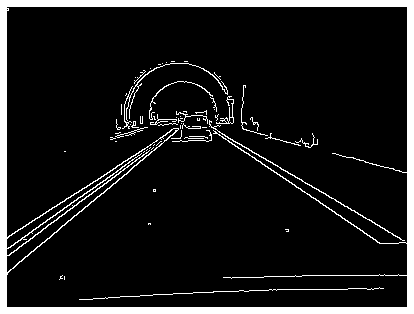

Accumulator image:


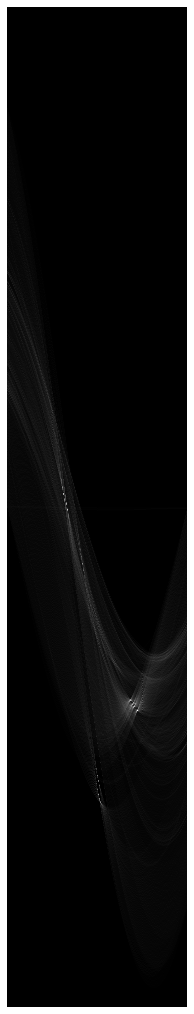

Detected lines:


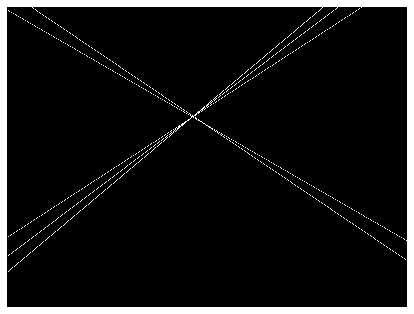

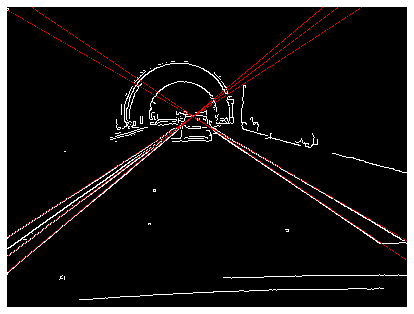

In [2]:
# write your code here

# read the image as a grayscale image (parameter 0) and plot it
img = cv2.imread('images/lane.png', 0)
rows, cols = img.shape
print("Binary image:")
plot_img_orig(img)

# compute range of parameter space
rho_max = np.ceil(np.sqrt(rows*rows + cols*cols))
rho = np.arange(-rho_max, rho_max) # last value is not included

theta_max = 90
theta = np.arange(-theta_max, theta_max)

# create empty accumulator image
accu = np.zeros((len(rho), len(theta)), dtype=np.uint64)

# compute function values
for i in range(rows):
    for j in range(cols):
        if img[i, j] > 0: # edge pixel found
            
            # compute rho for all theta values
            for t in range(len(theta)):
                rho_t = int((i*np.cos(theta[t]*np.pi/180) + j*np.sin(theta[t]*np.pi/180)) + rho_max) # offset of rho_max to get positive values
                theta_t = theta[t] + theta_max
            
                # write result to accumulator image
                accu[rho_t, theta_t] += 1
                
# plot of the accumulator image
accu_n = cv2.normalize(accu, None, 0, 255, cv2.NORM_MINMAX)
print("Accumulator image:")
plot_img_orig(accu_n)

# search for n largest maxima in accumulator image
n = 5
accu_flat = accu.flatten()
max_idx = np.argpartition(accu_flat, -n)[-n:]

# get rho and theta values of each maximum, then draw lines
lines = np.zeros(img.shape, dtype=np.uint64)

for i in range(len(max_idx)):
    rho_i = np.unravel_index(max_idx[i], accu.shape)[0]
    theta_i = np.unravel_index(max_idx[i], accu.shape)[1]
    
    # remove offset
    rho_i = rho_i - rho_max
    theta_i = theta_i - theta_max
    
    # draw lines
    for x in range(rows):
        y = int((rho_i - x * np.cos(theta_i*np.pi/180))/np.sin(theta_i*np.pi/180))
        if y > 0 and y < cols:
            lines[x, y] = 255

# image with detected lines
print("Detected lines:")
plot_img_orig(lines)

# overlay colored lines on binary image
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img_rgb[np.where(lines > 0)] = [255, 0, 0]

plot_img_orig(img_rgb)

#### <span style="color: RoyalBlue; font-weight: bold;">Task 3.2</span> Region Growing

Region growing is a method that groups pixels or subregions into larger regions based on predefined criteria for growing. It is common to start with seed pixels (starting points) and to grow the regions from these by appending neighbouring pixels with similar predefined properties as the seed (e.g., intensity ranges), and a specific connectivity (e.g., 8-connectivity). The growing process should stop when no more pixels satisfy the criteria for being added to the region. Region growing can be implemented in an iterative (sequential) or recursive manner.

When implemented in a sequential manner, the steps can be summarized as follows (the formalization is kept simple here for clarity, see lecture notes for details):
1. Determine unconnected (1 px) seed points (automatically or manually).
2. Form a binary image $f_Q$ which contains all pixels satisfying a given predicate $Q$.
3. Starting from the seeds, grow the regions by appending all 1-valued points in $f_Q$ that are 8-connected. It is convenient to use a separate image $g$ for this purpose.
4. Label each connected component in $g$ with a different region label (integer, color, etc.). This step can be combined with step 3.

The objective of this task is to segment the cells in the image *cells.png*. Appropriate seeds are provided in the image *cells-seeds.png*.

Implement / solve the following tasks:
1. Specify an appropriate predicate to segment the given image, then form and plot $f_Q$.
2. Create an image $g$ to hold the different labels.
3. Implement the region growing and define and implement an appropriate stopping criterion.
4. Assign a random color to each label and plot the result.

Grayscale image:


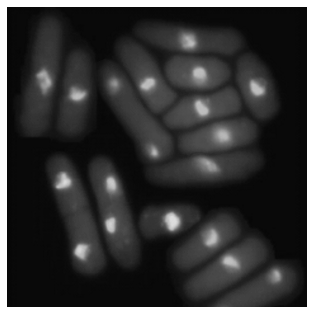

Seeds:


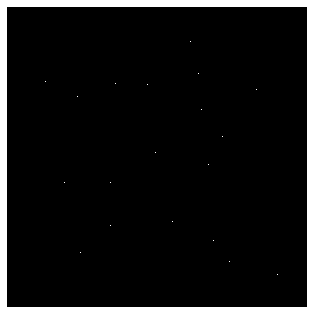

Global predicate TRUE:


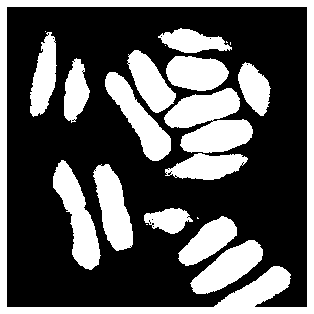

Segmentation result:


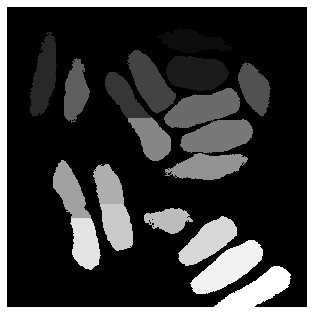

Last seeds (unprocessed neighbors):


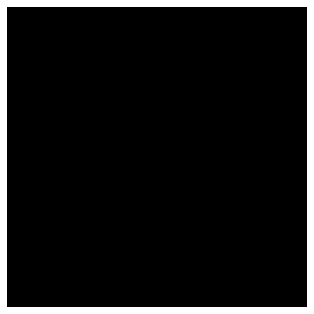

Colored segmentation result:


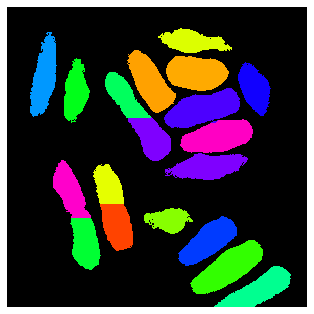

In [3]:
# write your code here

# read the image as a grayscale image (parameter 0) and plot it
img = cv2.imread('images/cells.png', 0)
rows, cols = img.shape
print("Grayscale image:")
plot_img_orig(img)

# seed image
seeds = cv2.imread('images/cells-seeds.png', 0)
print("Seeds:")
plot_img_orig(seeds)

# predicate: only consider pixels above threshold
threshold = 51
img_q = (img > threshold) * 255

print("Global predicate TRUE:")
plot_img_orig(img_q)

# image with labels
labels = np.zeros(img.shape, dtype=np.uint64) # init with zeros

# assign a label to each seed
label = 1
for i in range(rows):
    for j in range(cols):
        if seeds[i, j] == 255:
            labels[i, j] = label
            label += 1 # increment label for next seed pixel
            
seeds_new = np.zeros(img.shape, dtype=np.uint8) # init with zeros

# grow regions as long as neighbors are added
n = -1 # number of unprocessed neighbors
#for k in range(12): # for a fixed number of overall iterations
while n != 0: # stopping criterion n = 0
    n = 0
    
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            if seeds[i, j] > 0:
                #print("ij = " + str(i) + ", " + str(j))

                # check for unprocessed neighbors
                if img_q[i-1, j-1] == 255 and labels[i-1, j-1] == 0:
                    labels[i-1, j-1] = labels[i, j]
                    seeds_new[i-1, j-1] = 255
                    n += 1

                if img_q[i-1, j] == 255 and labels[i-1, j] == 0:
                    labels[i-1, j] = labels[i, j]
                    seeds_new[i-1, j] = 255
                    n += 1

                if img_q[i-1, j+1] == 255 and labels[i-1, j+1] == 0:
                    labels[i-1, j+1] = labels[i, j]
                    seeds_new[i-1, j+1] = 255
                    n += 1

                if img_q[i, j+1] == 255 and labels[i, j+1] == 0:
                    labels[i, j+1] = labels[i, j]
                    seeds_new[i, j+1] = 255
                    n += 1

                if img_q[i+1, j+1] == 255 and labels[i+1, j+1] == 0:
                    labels[i+1, j+1] = labels[i, j]
                    seeds_new[i+1, j+1] = 255
                    n += 1

                if img_q[i+1, j] == 255 and labels[i+1, j] == 0:
                    labels[i+1, j] = labels[i, j]
                    seeds_new[i+1, j] = 255
                    n += 1

                if img_q[i+1, j-1] == 255 and labels[i+1, j-1] == 0:
                    labels[i+1, j-1] = labels[i, j]
                    seeds_new[i+1, j-1] = 255
                    n += 1

                if img_q[i, j-1] == 255 and labels[i, j-1] == 0:
                    labels[i, j-1] = labels[i, j]
                    seeds_new[i, j-1] = 255
                    n += 1

                #print(n)
        
    # clear seed image
    seeds = seeds_new
    seeds_new = 0 * seeds_new
    
# plot of the label image
labels_n = cv2.normalize(labels, None, 0, 255, cv2.NORM_MINMAX)
print("Segmentation result:")
plot_img_orig(labels_n)

# plot new seeds
print("Last seeds (unprocessed neighbors):")
plot_img_orig(seeds)

# colored segmentation result
colors = np.random.randint(0, 180, 50) # create 50 values in the range between [0, 179]
#print(colors)

labels_hsv = np.zeros(shape=[rows, cols, 3], dtype=np.uint8) # init with zeros
labels_hsv[:,:,1] = 255 # saturation

for i in range(rows):
    for j in range(cols):
        if labels[i, j] > 0:
            val = labels[i, j] # get current gray value
            
            labels_hsv[i, j, 0] = colors[val] # assign color value
            labels_hsv[i, j, 2] = 255 # set value (brightness) to maximum

print("Colored segmentation result:")
labels_rgb = cv2.cvtColor(labels_hsv, cv2.COLOR_HSV2RGB)
plot_img_orig(labels_rgb)

Note that this implementation is quite naive, because it involves a large number of neighbor checks. The number of checks might be reduced by avoiding redundant checks, using another growing scheme, or by using a recursive implementation. In general, region growing can be implemented in several different manners.

In this example, some of the cells contain two regions because they contain two seeds - these regions can be merged directly or after the segmentation with additional steps (depending on the way steps 3 and 4 are implemented). The cells are seperated by horizontal borders due to the specific region growing method implemented here and might be different for other methods.